In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
# Download the dataset
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

In [ ]:
# Unzip the dataset
!tar -xf dogs-vs-cats-redux-kernels-edition.zip
!tar -xf test.zip
!tar -xf train.zip

***DATA EXPLORATION***

Let's have a look at the images in the folders, to get an idea of the data that we have. It is always important to have a look at the data before starting to work with it.

In [1]:
# Import modules
import os
from PIL import Image
import random
import matplotlib.pyplot as plt

In [2]:
print("Number of training images: ",len(os.listdir("train")))
print("Number of testing images: ",len(os.listdir("test")))

Number of training images:  25000
Number of testing images:  12500


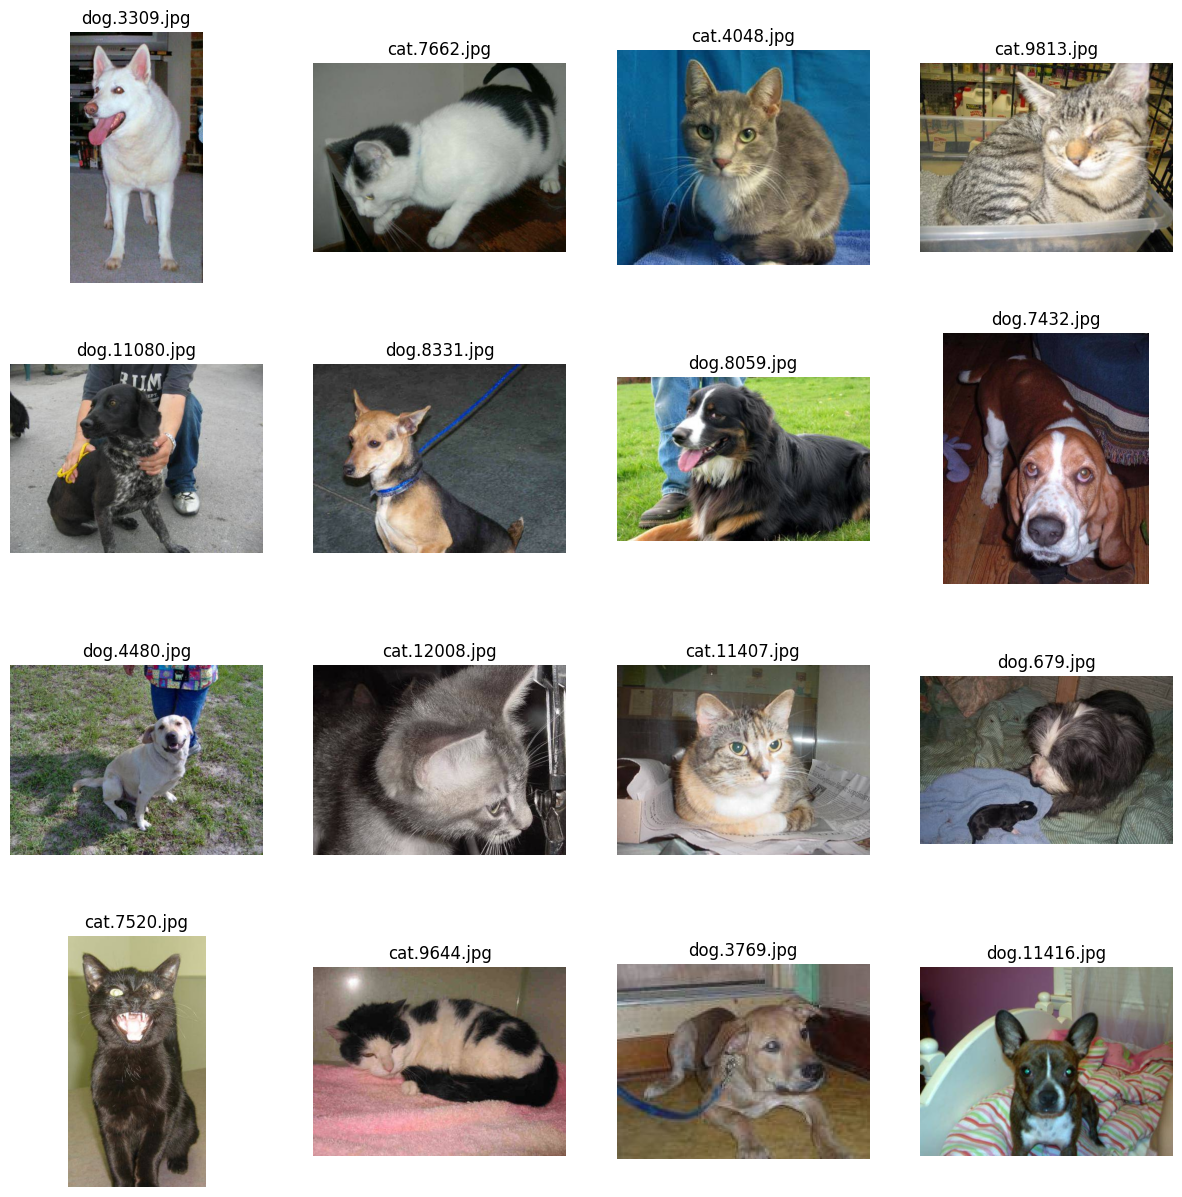

In [6]:
# Explore the data in the train folder

files_train = os.listdir("train")
random.shuffle(files_train)
fig = plt.figure(figsize=(15,15))
num_images = 16
for num, fn in enumerate(files_train[:num_images]):
  path = os.path.join("train",fn)
  img = Image.open(path)
  plt.subplot(num_images//4,4,num+1)
  plt.title(fn)
  plt.axis('off')
  plt.imshow(img)

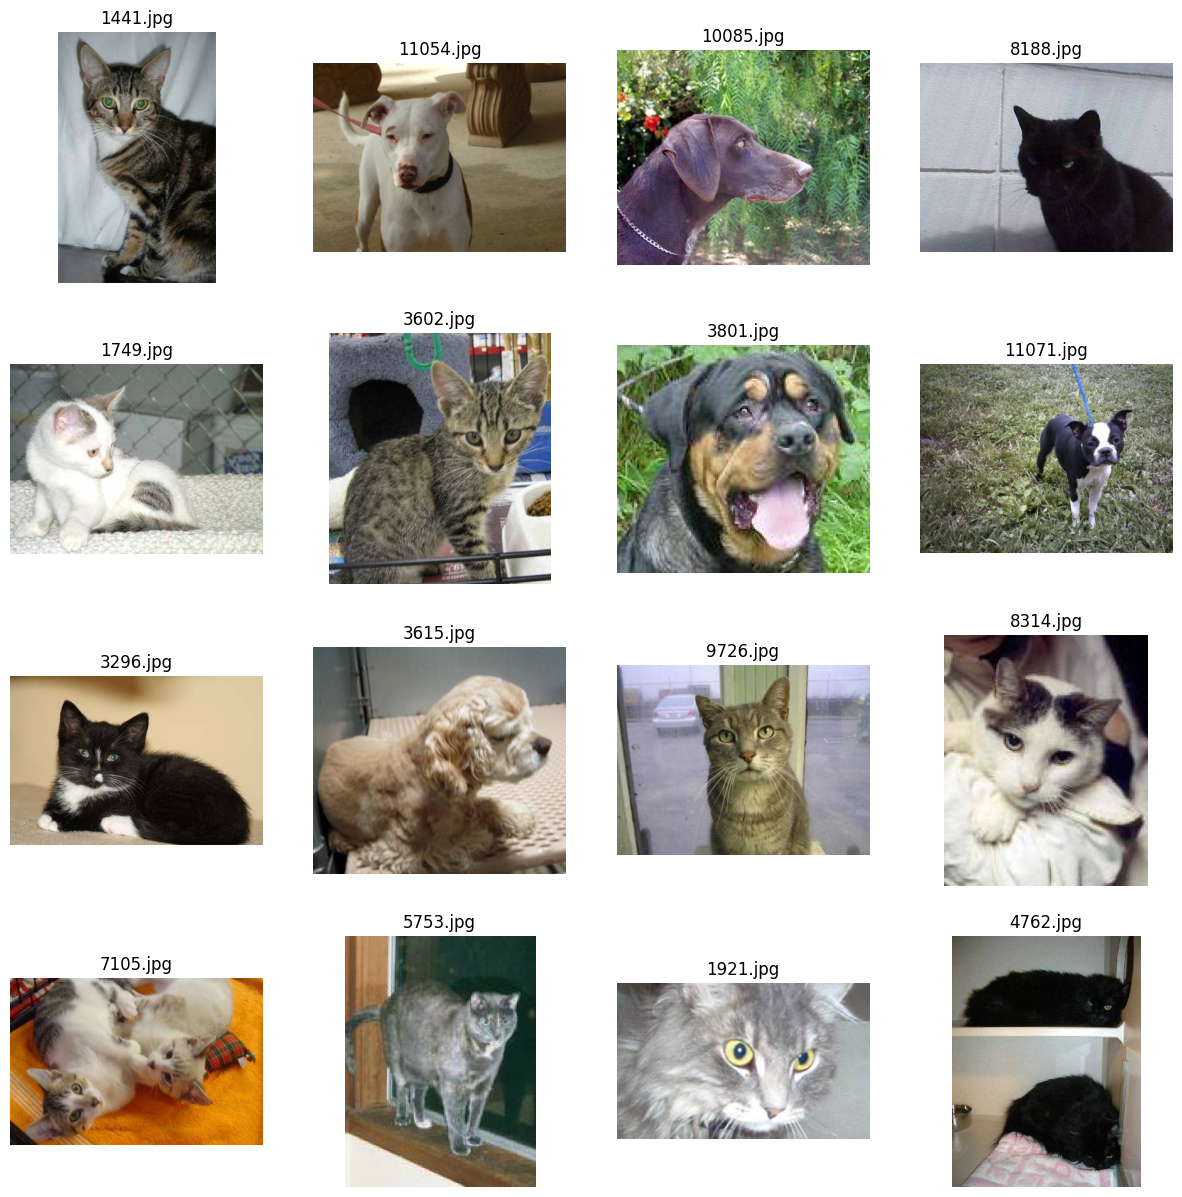

In [4]:
# Explore the data in the test folder

files_train = os.listdir("test")
random.shuffle(files_train)
fig = plt.figure(figsize=(15,15))
num_images = 16
for num, fn in enumerate(files_train[:num_images]):
  path = os.path.join("test",fn)
  img = Image.open(path)
  plt.subplot(num_images//4,4,num+1)
  plt.title(fn)
  plt.axis('off')
  plt.imshow(img)

**CODE PART 5: BUILDING AND TRAINING PLAIN-CNN**

We will build and train a plain convolutional neural network without skip-connections, following the architecture described in the paper by
He et al.

In [3]:
import torch
import torch.nn as nn
from dataset import get_datasets, get_loaders
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
import pickle

# Mettere foto della rete 
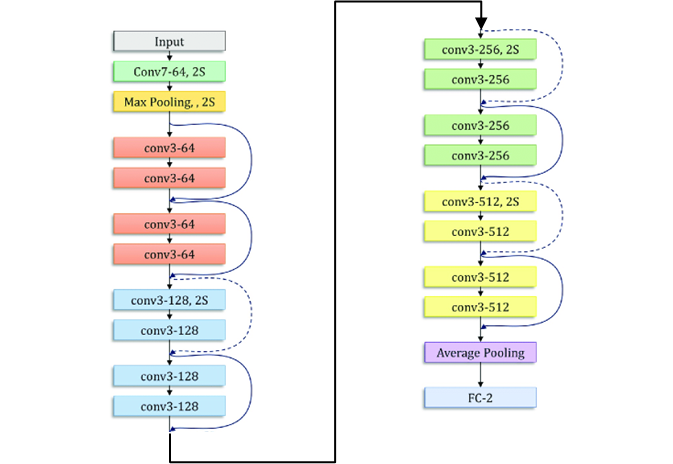

In [4]:
class PlainBlock(nn.Module):
    '''
    Implements one block of the plain CNN network described in the paper "Deep residual learning for image recognition" by He et al. (2015)
    '''
    def __init__(self, in_ch, out_ch, kernel_size, num_layers, first_layer_stride=2, padding=1):
        super(PlainBlock, self).__init__()
        self.layers = []
        for i in range(num_layers):
            if(i==0):
                self.layers.append(nn.Conv2d(in_ch, out_ch, kernel_size, stride=first_layer_stride, bias=False, padding=padding))
            else:
                self.layers.append(nn.Conv2d(out_ch, out_ch, kernel_size, stride=1, bias=False, padding=padding))

            self.layers.append(nn.BatchNorm2d(out_ch))
            self.layers.append(nn.ReLU(inplace=True))
        
        self.layers = nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.layers(x)

class PlainCNN(nn.Module):
    def __init__(self, config, n_classes):
        super(PlainCNN, self).__init__()
        self.config = config

        self.pool = nn.MaxPool2d(2, 2)

        self.block1 = PlainBlock(3, 64, 7, config[0], first_layer_stride=2, padding=3)
        self.block2 = PlainBlock(64, 64, 3, config[1], first_layer_stride=1)
        self.block3 = PlainBlock(64, 128, 3, config[2], first_layer_stride=2)
        self.block4 = PlainBlock(128, 256, 3, config[3], first_layer_stride=2)
        self.block5 = PlainBlock(256, 512, 3, config[4], first_layer_stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512,n_classes)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x
    
    def test_forward(self, x):
        '''
        This function is used to test the forward pass of the network. We can use it to check the shapes of the tensors at each layer.
        '''
        print(x.shape)
        x = self.block1(x)
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        x = self.block2(x)
        print(x.shape)
        x = self.block3(x)
        print(x.shape)
        x = self.block4(x)
        print(x.shape)
        x = self.block5(x)
        print(x.shape)
        x = self.avg_pool(x)
        print(x.shape)
        x = torch.flatten(x, start_dim=1)
        print(x.shape)
        x = self.fc(x)
        print(x.shape)

In [5]:
# Testing the forward function e spiegare la formula per calcolare le dimensioni in una CNN
net = PlainCNN([1,4,4,4,4],n_classes=1)
net.test_forward(torch.randn(1,3,224,224))

torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 1])


In [6]:
# Define the transformations that we want to apply in training and inference 

import torchvision.transforms as transf

transforms_train = transf.Compose([transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transforms_test_val = transf.Compose([transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
trainset, valset, testset = get_datasets("train", "test", 0.1, 0.5, transforms_train, transforms_test_val)
trainloader, valloader, testloader = get_loaders(trainset, valset, testset, 16, 8, True)

##############################################################################

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = PlainCNN([1,4,4,4,4], n_classes=1)
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Tot trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 20 

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Get the loss function 
loss_fn = BCEWithLogitsLoss(reduction="mean")

# Store the training and validation accuracies and losses in lists for plotting
acc_train = []
loss_train = []
acc_val = []
loss_val = []
log_every = 100

# Start the training loop
for epoch in range(epochs):
  loss_training = 0
  accuracy_training = 0 
  print("Epoch:", epoch)
  for i, data in enumerate(tqdm(trainloader)):
    imgs, labels = data
    # Send data to GPU
    imgs = imgs.to(device)
    labels = labels.to(device)
    predictions = model(imgs)
    loss = loss_fn(predictions.squeeze(),labels.view(-1))
    # Zero the gradients in the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_training += loss.item()
    # Calculate the training accuracy 
    predictions = torch.sigmoid(predictions.detach().squeeze())
    accuracy_training += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    if i%log_every == 0 and i!=0:
      loss_train.append(loss.item())
      acc_train.append((sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item())
    
  
  # Test on validation images 
  loss_validation = 0
  accuracy_validation = 0
  with torch.no_grad():
    model.eval()
    for i, data in enumerate(tqdm(valloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions.squeeze(),labels.view(-1))
      loss_validation += loss.item()
      # Calculate the training accuracy 
      predictions = torch.sigmoid(predictions.detach().squeeze())
      accuracy_validation += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    
    acc_val.append(accuracy_validation/len(valloader))
    loss_val.append(loss_validation/len(valloader))
      
    # Put again model in training mode
    model.train()
  

  print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
  print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
  print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
  print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

# Save the weights of the network after the training has finished
torch.save(model.state_dict(), "weights/weight_plain18.pth")

# Save the lists for plotting 
with open("figures/plain/acc_train18.pkl","wb") as f:
  pickle.dump(acc_train,f)
with open("figures/plain/loss_train18.pkl","wb") as f:
  pickle.dump(loss_train,f)
with open("figures/plain/acc_val18.pkl","wb") as f:
  pickle.dump(acc_val,f)
with open("figures/plain/loss_val18.pkl","wb") as f:
  pickle.dump(loss_val,f)

In [ ]:
# Explore the training and validation curves 
with open("figures/plain/acc_train18.pkl","rb") as f:
  acc_train = pickle.load(f)
with open("figures/plain/loss_train18.pkl","rb") as f:
  loss_train = pickle.load(f)
with open("figures/plain/acc_val18.pkl","rb") as f:
  acc_val = pickle.load(f)
with open("figures/plain/loss_val18.pkl","rb") as f:
  loss_val = pickle.load(f)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(acc_train, label="Training accuracy")
plt.plot(loss_train, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_val, label="Validation accuracy")
plt.plot(loss_val, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Explore the data 
files_test = os.listdir("test")
random.seed(0)
random.shuffle(files_test)
fig = plt.figure(figsize=(15,15))
num_images = 16
transforms_test = transf.Compose([
                            transf.ToTensor(),
                            transf.Resize((224,224)), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
model.eval()
with torch.no_grad():
  for num, fn in enumerate(files_test[:num_images]):
    path = os.path.join("test",fn)
    img = Image.open(path)
    out = model(transforms_test(img).unsqueeze(0).to(device))
    out = torch.sigmoid(out.squeeze())
    prediction = torch.round(out)
    plt.subplot(num_images//4,4,num+1)
    plt.axis('off')
    plt.imshow(img)
    if(prediction):
      plt.title("This is a dog!\n"+str(round(out.item(),2)))
    else:
      plt.title("This is a cat!\n"+str(round(out.item(),2)))

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/weight_plain18.pth")

***BUILDING AND TRAINING SKIPCNN***

In this part, we will build and train a "resnet" convolutional neural network with skip-connections, again following the architecture described in the paper by He et al.  

In [13]:
class SkipLayer(nn.Module):
    '''
    Implements a single skip connection sub-block of the residual CNN. It consists of two convolutional layers with batch normalization and ReLU activation.
    '''
    def __init__(self, in_ch, out_ch, kernel_size, stride_first_conv=1):
        super(SkipLayer, self).__init__()
        layers = []
        self.stride_first_conv = stride_first_conv
        if(stride_first_conv!=1):
            self.conv1x1 = nn.Conv2d(in_ch, in_ch*2, 1, stride=stride_first_conv, bias=False)
            self.bn = nn.BatchNorm2d(in_ch*2)
        # Append first convolutional layer
        layers.append(nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride_first_conv, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.ReLU(inplace=True))
        # Append second convolutional layer
        layers.append(nn.Conv2d(out_ch, out_ch, kernel_size, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_ch))
        self.layers = nn.Sequential(*layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x 
        out = self.layers(x)

        if self.stride_first_conv!=1:
            # Project the identity to match the correct dimension
            identity = self.bn(self.conv1x1(identity))

        return self.relu(out + identity)

class SkipBlock(nn.Module):
    '''
    Implements one block of the residual CNN described in the paper "Deep residual learning for image recognition" by He et al. (2015)
    Here block refers to the different coloured parts of the network in the figure of the paper.
    '''
    def __init__(self, in_ch, out_ch, kernel_size, num_layers, first_layer_stride=2):
        super(SkipBlock, self).__init__()
        layers = []

        # Append the skip connections
        for i in range(num_layers):
            if i == 0:
                layers.append(SkipLayer(in_ch, out_ch, kernel_size, stride_first_conv=first_layer_stride))
            else:
                layers.append(SkipLayer(out_ch, out_ch, kernel_size, stride_first_conv=1))
        
        self.layers = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.layers(x)

class SkipCNN(nn.Module):
    def __init__(self, config, n_classes=1):
        super(SkipCNN, self).__init__()
        self.config = config

        self.pool = nn.MaxPool2d(2, 2)
        self.block1 = PlainBlock(3, 64, 7, config[0], first_layer_stride=2)
        self.block2 = SkipBlock(64, 64, 3, config[1], first_layer_stride=1)
        self.block3 = SkipBlock(64, 128, 3, config[2], first_layer_stride=2)
        self.block4 = SkipBlock(128, 256, 3, config[3], first_layer_stride=2)
        self.block5 = SkipBlock(256, 512, 3, config[4], first_layer_stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_classes)

    
    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x
    
    def test_forward(self, x):
        x = self.block1(x)
        print("First block")
        print(x.shape)
        x = self.pool(x)
        print("Pool")
        print(x.shape)
        x = self.block2(x)
        print("Second block")
        print(x.shape)
        x = self.block3(x)
        print("Third block")
        print(x.shape)
        x = self.block4(x)
        print("Fourth block")
        print(x.shape)
        x = self.block5(x)
        print("Fifth block")
        print(x.shape)
        x = self.avg_pool(x)
        print(x.shape)
        x = torch.flatten(x, start_dim=1)
        print(x.shape)
        x = self.fc(x)
        print(x.shape)

In [ ]:
trainset, valset, testset = get_datasets("train", "test", 0.1, 0.5, transforms_train, transforms_test_val)
trainloader, valloader, testloader = get_loaders(trainset, valset, testset, 16, 8, True)

##############################################################################

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = SkipCNN([1,2,2,2,2], n_classes=1)
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Tot trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 20 

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Get the loss function 
loss_fn = BCEWithLogitsLoss(reduction="mean")

# Store the training and validation accuracies and losses in lists for plotting
acc_train = []
loss_train = []
acc_val = []
loss_val = []
log_every = 100

# Start the training loop
for epoch in range(epochs):
  loss_training = 0
  accuracy_training = 0 
  print("Epoch:", epoch)
  for i, data in enumerate(tqdm(trainloader)):
    imgs, labels = data
    # Send data to GPU
    imgs = imgs.to(device)
    labels = labels.to(device)
    predictions = model(imgs)
    loss = loss_fn(predictions.squeeze(),labels.view(-1))
    # Zero the gradients in the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_training += loss.item()
    # Calculate the training accuracy 
    predictions = torch.sigmoid(predictions.detach().squeeze())
    accuracy_training += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    if i%log_every == 0 and i!=0:
      loss_train.append(loss.item())
      acc_train.append((sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item())
    
  
  # Test on validation images 
  loss_validation = 0
  accuracy_validation = 0
  with torch.no_grad():
    model.eval()
    for i, data in enumerate(tqdm(valloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions.squeeze(),labels.view(-1))
      loss_validation += loss.item()
      # Calculate the training accuracy 
      predictions = torch.sigmoid(predictions.detach().squeeze())
      accuracy_validation += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    
    acc_val.append(accuracy_validation/len(valloader))
    loss_val.append(loss_validation/len(valloader))
      
    # Put again model in training mode
    model.train()

  print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
  print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
  print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
  print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

# Save the weights of the network
torch.save(model.state_dict(), "weights/weight_skip18.pth")

# Save the lists for plotting 
with open("figures/skip/acc_train18.pkl","wb") as f:
  pickle.dump(acc_train,f)
with open("figures/skip/loss_train18.pkl","wb") as f:
  pickle.dump(loss_train,f)
with open("figures/skip/acc_val18.pkl","wb") as f:
  pickle.dump(acc_val,f)
with open("figures/skip/loss_val18.pkl","wb") as f:
  pickle.dump(loss_val,f)

In [ ]:
# Explore the training and validation curves 
with open("figures/skip/acc_train18.pkl","rb") as f:
  acc_train = pickle.load(f)
with open("figures/skip/loss_train18.pkl","rb") as f:
  loss_train = pickle.load(f)
with open("figures/skip/acc_val18.pkl","rb") as f:
  acc_val = pickle.load(f)
with open("figures/skip/loss_val18.pkl","rb") as f:
  loss_val = pickle.load(f)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(acc_train, label="Training accuracy")
plt.plot(loss_train, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_val, label="Validation accuracy")
plt.plot(loss_val, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Let's predict on some data of the test set! 

# Load the model 
model = SkipCNN([1,2,2,2,2], n_classes=1)
model.load_state_dict(torch.load("trained_models/weight_skip18.pth"))
model.to(device)

files_test = os.listdir("test")
random.seed(0)
random.shuffle(files_test)
fig = plt.figure(figsize=(15,15))
num_images = 16
transforms_test = transf.Compose([
                            transf.ToTensor(),
                            transf.Resize((224,224)), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
model.eval()
with torch.no_grad():
  for num, fn in enumerate(files_test[:num_images]):
    path = os.path.join("test",fn)
    img = Image.open(path)
    out = model(transforms_test(img).unsqueeze(0).to(device))
    out = torch.sigmoid(out.squeeze())
    prediction = torch.round(out)
    plt.subplot(num_images//4,4,num+1)
    plt.axis('off')
    plt.imshow(img)
    if(prediction):
      plt.title("This is a dog!\n"+str(round(out.item(),2)))
    else:
      plt.title("This is a cat!\n"+str(round(out.item(),2)))

It seems that with this shallow architecture, the skip-connections are not really necessary. Let's try with a deeper architecture, and see if the skip-connections help.

In [ ]:
trainset, valset, testset = get_datasets("train", "test", 0.1, 0.5, transforms_train, transforms_test_val)
trainloader, valloader, testloader = get_loaders(trainset, valset, testset, 16, 8, True)

##############################################################################

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = PlainCNN([1,6,8,12,6])
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Tot trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 20 

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Get the loss function 
loss_fn = BCEWithLogitsLoss(reduction="mean")

acc_train = []
loss_train = []
acc_val = []
loss_val = []
log_every = 100

# Start the training loop
for epoch in range(epochs):
  loss_training = 0
  accuracy_training = 0 
  print("Epoch:", epoch)
  for i, data in enumerate(tqdm(trainloader)):
    imgs, labels = data
    # Send data to GPU
    imgs = imgs.to(device)
    labels = labels.to(device)
    predictions = model(imgs)
    loss = loss_fn(predictions.squeeze(),labels.view(-1))
    # Zero the gradients in the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_training += loss.item()
    # Calculate the training accuracy 
    predictions = torch.sigmoid(predictions.detach().squeeze())
    accuracy_training += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    if i%log_every == 0 and i!=0:
      loss_train.append(loss.item())
      acc_train.append((sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item())
    
  
  # Test on validation images 
  loss_validation = 0
  accuracy_validation = 0
  with torch.no_grad():
    model.eval()
    for i, data in enumerate(tqdm(valloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions.squeeze(),labels.view(-1))
      loss_validation += loss.item()
      # Calculate the training accuracy 
      predictions = torch.sigmoid(predictions.detach().squeeze())
      accuracy_validation += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    
    acc_val.append(accuracy_validation/len(valloader))
    loss_val.append(loss_validation/len(valloader))
      
    # Put again model in training mode
    model.train()

  print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
  print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
  print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
  print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

# Save the lists for plotting 
with open("figures/plain/acc_train_34.pkl","wb") as f:
  pickle.dump(acc_train,f)
with open("figures/plain/loss_train_34.pkl","wb") as f:
  pickle.dump(loss_train,f)
with open("figures/plain/acc_val_34.pkl","wb") as f:
  pickle.dump(acc_val,f)
with open("figures/plain/loss_val_34.pkl","wb") as f:
  pickle.dump(loss_val,f)

In [ ]:
# Explore the training and validation curves 
with open("figures/plain/acc_train_34.pkl","rb") as f:
  acc_train = pickle.load(f)
with open("figures/plain/loss_train_34.pkl","rb") as f:
  loss_train = pickle.load(f)
with open("figures/plain/acc_val_34.pkl","rb") as f:
  acc_val = pickle.load(f)
with open("figures/plain/loss_val_34.pkl","rb") as f:
  loss_val = pickle.load(f)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(acc_train, label="Training accuracy")
plt.plot(loss_train, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_val, label="Validation accuracy")
plt.plot(loss_val, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/weight_plain34.pth")

In [ ]:
trainset, valset, testset = get_datasets("train", "test", 0.1, 0.5, transforms_train, transforms_test_val)
trainloader, valloader, testloader = get_loaders(trainset, valset, testset, 16, 8, True)

##############################################################################

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = SkipCNN([1,3,4,6,3])
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Tot trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 20 

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Get the loss function 
loss_fn = BCEWithLogitsLoss(reduction="mean")

# Store the training and validation accuracies and losses in lists for plotting
acc_train = []
loss_train = []
acc_val = []
loss_val = []
log_every = 100

# Start the training loop
for epoch in range(epochs):
  loss_training = 0
  accuracy_training = 0 
  print("Epoch:", epoch)
  for i, data in enumerate(tqdm(trainloader)):
    imgs, labels = data
    # Send data to GPU
    imgs = imgs.to(device)
    labels = labels.to(device)
    predictions = model(imgs)
    loss = loss_fn(predictions.squeeze(),labels.view(-1))
    # Zero the gradients in the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_training += loss.item()
    # Calculate the training accuracy 
    predictions = torch.sigmoid(predictions.detach().squeeze())
    accuracy_training += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    if i%log_every == 0 and i!=0:
      loss_train.append(loss.item())
      acc_train.append((sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item())
    
  
  # Test on validation images 
  loss_validation = 0
  accuracy_validation = 0
  with torch.no_grad():
    model.eval()
    for i, data in enumerate(tqdm(valloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions.squeeze(),labels.view(-1))
      loss_validation += loss.item()
      # Calculate the training accuracy 
      predictions = torch.sigmoid(predictions.detach().squeeze())
      accuracy_validation += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    
    acc_val.append(accuracy_validation/len(valloader))
    loss_val.append(loss_validation/len(valloader))
      
    # Put again model in training mode
    model.train()

  print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
  print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
  print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
  print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

# Save the lists for plotting 
with open("figures/skip/acc_train34.pkl","wb") as f:
  pickle.dump(acc_train,f)
with open("figures/skip/loss_train34.pkl","wb") as f:
  pickle.dump(loss_train,f)
with open("figures/skip/acc_val34.pkl","wb") as f:
  pickle.dump(acc_val,f)
with open("figures/skip/loss_val34.pkl","wb") as f:
  pickle.dump(loss_val,f)

In [ ]:
# Explore the training and validation curves 
with open("figures/skip/acc_train34.pkl","rb") as f:
  acc_train = pickle.load(f)
with open("figures/skip/loss_train34.pkl","rb") as f:
  loss_train = pickle.load(f)
with open("figures/skip/acc_val34.pkl","rb") as f:
  acc_val = pickle.load(f)
with open("figures/skip/loss_val34.pkl","rb") as f:
  loss_val = pickle.load(f)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(acc_train, label="Training accuracy")
plt.plot(loss_train, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_val, label="Validation accuracy")
plt.plot(loss_val, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/weight_skip34.pth")

In [ ]:
# Explore the data 
files_test = os.listdir("test")
random.seed(0)
random.shuffle(files_test)
fig = plt.figure(figsize=(15,15))
num_images = 16
transforms_test = transf.Compose([
                            transf.ToTensor(),
                            transf.Resize((224,224)), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
model.eval()
with torch.no_grad():
  for num, fn in enumerate(files_test[:num_images]):
    path = os.path.join("test",fn)
    img = Image.open(path)
    out = model(transforms_test(img).unsqueeze(0).to(device))
    out = torch.sigmoid(out.squeeze())
    prediction = torch.round(out)
    plt.subplot(num_images//4,4,num+1)
    plt.axis('off')
    plt.imshow(img)
    if(prediction):
      plt.title("This is a dog!\n"+str(round(out.item(),2)))
    else:
      plt.title("This is a cat!\n"+str(round(out.item(),2)))

In [ ]:
# Qui mettere un grafico con tutte le run per compararle

**CODE PART 7: TRANSFER LEARNING**

In general, building a network from scratch and training it with limited data is not a good idea!
Transfer learning equip us with a strategy to leverage a pre-trained model, and adapt it to fit our task. Furthermore, pretrained networks are able to extract very general and powerful representations, which can be very useful when fine-tuned on a target dataset. 
In general, we will try to a pretrained resnet18 model, which have been trained on the ImageNet dataset (a large image classification dataset), and then fine-tune it on our cats vs dogs dataset, to see if we can achieve a better accuracy.

Usually, transfer learning is first done in those steps:
- modify the last layer of the network to fit the number of classes of the target dataset. 
- train the network by freezing all the layers in the network except the one modified.
- unfreeze the network, and train the whole network for some epochs with a lower learning rate.

Let's see how straightforward it is to do this in PyTorch.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights # Import the resnet architecture and pretrained weights from torchvision.models 


trainset, valset, testset = get_datasets("train", "test", 0.1, 0.5, transforms_train, transforms_test_val)
trainloader, valloader, testloader = get_loaders(trainset, valset, testset, 16, 8, True)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = resnet18(weights=ResNet18_Weights.DEFAULT) 
# Replace the last layer to fit the output classes of the new task.
model.fc = nn.Linear(512,1)
# Freeze all layers except the last fully conneceted layer
for name, param in model.named_parameters():
  if 'fc' not in name:
    param.requires_grad = False
    
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Tot trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 1e-3 # With transfer learning we can use a lower learning rate
epochs = 20

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-4, momentum=0.9) 

# Get the loss function 
loss_fn = BCEWithLogitsLoss(reduction="mean")

# Store the training and validation accuracies and losses in lists for plotting
acc_train = []
loss_train = []
acc_val = []
loss_val = []
log_every = 100

# Start the training loop
for epoch in range(epochs):
  loss_training = 0
  accuracy_training = 0 
  print("Epoch:", epoch)
  for i, data in enumerate(tqdm(trainloader)):
    imgs, labels = data
    # Send data to GPU
    imgs = imgs.to(device)
    labels = labels.to(device)
    predictions = model(imgs)
    loss = loss_fn(predictions.squeeze(),labels.view(-1))
    # Zero the gradients in the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_training += loss.item()
    # Calculate the training accuracy 
    predictions = torch.sigmoid(predictions.detach().squeeze())
    accuracy_training += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    if i%log_every == 0 and i!=0:
      loss_train.append(loss.item())
      acc_train.append((sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item())
    
  
  # Test on validation images 
  loss_validation = 0
  accuracy_validation = 0
  with torch.no_grad():
    model.eval()
    for i, data in enumerate(tqdm(valloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions.squeeze(),labels.view(-1))
      loss_validation += loss.item()
      # Calculate the training accuracy 
      predictions = torch.sigmoid(predictions.detach().squeeze())
      accuracy_validation += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    
    acc_val.append(accuracy_validation/len(valloader))
    loss_val.append(loss_validation/len(valloader))
      
    # Put again model in training mode
    model.train()

  print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
  print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
  print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
  print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

# Save the lists for plotting 
with open("figures/transfer/acc_train_linear_probing.pkl","wb") as f:
  pickle.dump(acc_train,f)
with open("figures/transfer/loss_train_linear_probing.pkl","wb") as f:
  pickle.dump(loss_train,f)
with open("figures/transfer/acc_val_linear_probing.pkl","wb") as f:
  pickle.dump(acc_val,f)
with open("figures/transfer/loss_val_linear_probing.pkl","wb") as f:
  pickle.dump(loss_val,f)

In [ ]:
# Explore the data 
files_test = os.listdir("test")
random.seed(0)
random.shuffle(files_test)
fig = plt.figure(figsize=(15,15))
num_images = 16
transforms_test = transf.Compose([
                            transf.ToTensor(),
                            transf.Resize((224,224)), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
model.eval()
with torch.no_grad():
  for num, fn in enumerate(files_test[:num_images]):
    path = os.path.join("test",fn)
    img = Image.open(path)
    out = model(transforms_test(img).unsqueeze(0).to(device))
    out = torch.sigmoid(out.squeeze())
    prediction = torch.round(out)
    plt.subplot(num_images//4,4,num+1)
    plt.axis('off')
    plt.imshow(img)
    if(prediction):
      plt.title("This is a dog!\n"+str(round(out.item(),2)))
    else:
      plt.title("This is a cat!\n"+str(round(out.item(),2)))

In [ ]:
# Save the weights of the network
torch.save(model.state_dict(), "weights/resnet18_linear_probing.pth")

Now unfreeze the complete network and train it for 5 epochs with a lower learning rate.

In [ ]:
from torchvision.models import resnet18

trainset, valset, testset = get_datasets("train", "test", 0.1, 1, transforms_train, transforms_test_val) # Finetune on the complete dataset 
trainloader, valloader, testloader = get_loaders(trainset, valset, testset, 16, 8, True)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = resnet18() 
# Replace the last layer of the model with a new one
model.fc = nn.Linear(512,1)
# Load the previous weights to continue training
model.load_state_dict(torch.load("weights/resnet18_linear_probing.pth"))

model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Tot trainable parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 1e-4 # DECREASE THE LEARNING RATE
epochs = 5

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-6, momentum=0.9) # DECREASE WEIGHT DECAY

# Get the loss function 
loss_fn = BCEWithLogitsLoss(reduction="mean")

# Store the training and validation accuracies and losses in lists for plotting
acc_train = []
loss_train = []
acc_val = []
loss_val = []
log_every = 100

# Start the training loop
for epoch in range(epochs):
  loss_training = 0
  accuracy_training = 0 
  print("Epoch:", epoch)
  for i, data in enumerate(tqdm(trainloader)):
    imgs, labels = data
    # Send data to GPU
    imgs = imgs.to(device)
    labels = labels.to(device)
    predictions = model(imgs)
    loss = loss_fn(predictions.squeeze(),labels.view(-1))
    # Zero the gradients in the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_training += loss.item()
    # Calculate the training accuracy 
    predictions = torch.sigmoid(predictions.detach().squeeze())
    accuracy_training += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    if i%log_every == 0 and i!=0:
      loss_train.append(loss.item())
      acc_train.append((sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item())
    
  
  # Test on validation images 
  loss_validation = 0
  accuracy_validation = 0
  with torch.no_grad():
    model.eval()
    for i, data in enumerate(tqdm(valloader)):
      imgs, labels = data
      # Send data to GPU
      imgs = imgs.to(device)
      labels = labels.to(device)
      predictions = model(imgs)
      loss = loss_fn(predictions.squeeze(),labels.view(-1))
      loss_validation += loss.item()
      # Calculate the training accuracy 
      predictions = torch.sigmoid(predictions.detach().squeeze())
      accuracy_validation += (sum(torch.round(predictions)==labels.view(-1))/imgs.shape[0]).item()
    
    acc_val.append(accuracy_validation/len(valloader))
    loss_val.append(loss_validation/len(valloader))
      
    # Put again model in training mode
    model.train()

  print("\nTraining loss epoch ",epoch,":",loss_training/len(trainloader))
  print("Training accuracy epoch ",epoch,":",accuracy_training/len(trainloader))
  print("Validation loss epoch ",epoch,":",loss_validation/len(valloader))
  print("Validation accuracy epoch ",epoch,":",accuracy_validation/len(valloader))

# Save the lists for plotting 
with open("figures/transfer/acc_train_finetuning.pkl","wb") as f:
  pickle.dump(acc_train,f)
with open("figures/transfer/loss_train_finetuning.pkl","wb") as f:
  pickle.dump(loss_train,f)
with open("figures/transfer/acc_val_finetuning.pkl","wb") as f:
  pickle.dump(acc_val,f)
with open("figures/transfer/loss_val_finetuning.pkl","wb") as f:
  pickle.dump(loss_val,f)

In [ ]:
# Explore the data 
files_test = os.listdir("test")
random.seed(0)
random.shuffle(files_test)
fig = plt.figure(figsize=(15,15))
num_images = 16
transforms_test = transf.Compose([
                            transf.ToTensor(),
                            transf.Resize((224,224)), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
model.eval()
with torch.no_grad():
  for num, fn in enumerate(files_test[:num_images]):
    path = os.path.join("test",fn)
    img = Image.open(path)
    out = model(transforms_test(img).unsqueeze(0).to(device))
    out = torch.sigmoid(out.squeeze())
    prediction = torch.round(out)
    plt.subplot(num_images//4,4,num+1)
    plt.axis('off')
    plt.imshow(img)
    if(prediction):
      plt.title("This is a dog!\n"+str(round(out.item(),2)))
    else:
      plt.title("This is a cat!\n"+str(round(out.item(),2)))

In [ ]:
# Save the weights of the networks
torch.save(model.state_dict(), "weights/resnet18_finetuning.pth")

# LET'S TRY TO PREDICT MORE IMAGES WITH OUR MOST POWERFUL MODEL! 

In [ ]:
# Explore the data 
files_test = os.listdir("test")
random.seed(0)
random.shuffle(files_test)
fig = plt.figure(figsize=(15,80))
num_images = 128
transforms_test = transf.Compose([
                            transf.ToTensor(),
                            transf.Resize((224,224)), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
model.eval()
with torch.no_grad():
  for num, fn in enumerate(files_test[:num_images]):
    path = os.path.join("test",fn)
    img = Image.open(path)
    out = model(transforms_test(img).unsqueeze(0).to(device))
    prediction = out.squeeze()>0.5
    plt.subplot(num_images//4,4,num+1)
    plt.axis('off')
    plt.imshow(img)
    if(prediction):
      plt.title("This is a dog!")
    else:
      plt.title("This is a cat!")

Let's try to submit the solution to kaggle!

In [ ]:
# Submission must be in the format of a csv file with two columns: id and label
import csv

files_test = os.listdir("test")

with open('submission_kaggle.csv', 'w', newline='') as file:
  writer = csv.writer(file)

  writer.writerow(["id", "label"])
  model.eval()
  with torch.no_grad():
    for num, fn in enumerate(tqdm(files_test)): # ALL IMAGES
      id_img = fn.split(".")[0]
      path = os.path.join("test",fn)
      img = Image.open(path)
      out = model(transforms_test(img).unsqueeze(0).to(device))
      prediction = torch.clamp(out.squeeze(),min=0.02, max=0.98).item()
      writer.writerow([str(id_img),str(prediction)])
    

We would have been ended up in 196 th position out of more or less 1350 people!